In [1]:
import os
while os.getcwd()[-len('mcrc-cetuximab-analysis'):] != 'mcrc-cetuximab-analysis':
    os.chdir('..')
os.getcwd() 

'/home/max/mcrc-cetuximab-analysis'

In [2]:
import numpy as np
import pickle as pkl
import pandas as pd

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

import decoupler

/home/max/mcrc-cetuximab-analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/max/mcrc-cetuximab-analysis/.venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
counts = pd.read_csv('data/raw_counts_hgnc_filtered_by_ann.csv', index_col=0)
ann = pd.read_csv('data/ann.csv', index_col=0).rename(columns={'treatment response': 'treatment_response'})

In [4]:
counts = counts.loc[:,counts.max() > 10].astype(int)

In [5]:
ann

,tissue,time point,treatment_response,patient_id,sample_title,gsm_id
sample_id,,,,,,
18R649_0010,primary tumor (colorectum),post-treatment,non-PD,1,POST-R-001,GSM5575333
18R654_0015,primary tumor (colorectum),pre-treatment,non-PD,1,PAIR-R-001-pre,GSM5575334
18R669_0001,primary tumor (colorectum),post-treatment,non-PD,2,POST-R-002,GSM5575336
18R670_0002,primary tumor (colorectum),pre-treatment,non-PD,2,PAIR-R-002,GSM5575337
18R674_0006,primary tumor (colorectum),pre-treatment,unknown,3,PAIR-R-003,GSM5575339
...,...,...,...,...,...,...
18R454_0027,primary tumor (colorectum),pre-treatment,unknown,51,PRE-R-051,GSM5575441
18R477_0019,primary tumor (colorectum),pre-treatment,unknown,52,PRE-R-052,GSM5575442
18R507_0004,primary tumor (colorectum),pre-treatment,non-PD,10,PRE-10,GSM5575443


In [6]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts,
    metadata=ann,
    design="~treatment_response",
    refit_cooks=True,
    inference=inference,
    n_cpus=8, # n_cpus can be specified here or in the inference object
)

dds.deseq2()

with open(os.path.join('results', "deseq_on_all_by_resopnse.pkl"), "wb") as f:
    pkl.dump(dds, f)

Fitting size factors...
... done in 0.05 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 51.54 seconds.

Fitting dispersion trend curve...
... done in 3.53 seconds.

Fitting MAP dispersions...
... done in 48.82 seconds.

Fitting LFCs...
... done in 5.40 seconds.

Calculating cook's distance...
... done in 0.13 seconds.

Replacing 1156 outlier genes.

Fitting dispersions...
... done in 1.93 seconds.

Fitting MAP dispersions...
... done in 2.07 seconds.

Fitting LFCs...
... done in 0.59 seconds.



In [7]:
dds

AnnData object with n_obs × n_vars = 80 × 18309
    obs: 'tissue', 'time point', 'treatment_response', 'patient_id', 'sample_title', 'gsm_id'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'replace_cooks'

In [16]:
ds = DeseqStats(dds, contrast=["treatment_response", "PD", "non-PD"], inference=inference)
ds.summary(lfc_null=1.3, alt_hypothesis="greaterAbs")
with open(os.path.join('results', "ds.pkl"), "wb") as f:
    pkl.dump(ds, f)

Running Wald tests...
... done in 4.87 seconds.



Log2 fold change & Wald test p-value: treatment_response PD vs non-PD
                baseMean  log2FoldChange     lfcSE     stat    pvalue  padj
TSPAN6       4425.250977       -0.144219  0.308184  0.00000  1.000000   1.0
TNMD           38.584133       -0.109776  0.615318  0.00000  1.000000   1.0
DPM1         9724.985352        0.189719  0.241356  0.00000  1.000000   1.0
SCYL3         685.285522       -0.053223  0.116830  0.00000  1.000000   1.0
FIRRM        1652.466431       -0.273897  0.180548  0.00000  1.000000   1.0
...                  ...             ...       ...      ...       ...   ...
FAM90A23        0.234090       -1.196269  4.754845  0.00000  1.000000   1.0
FAM90A14        3.834275       -0.559328  1.884864  0.00000  1.000000   1.0
GET1-SH3BGR    22.956362       -1.248974  1.067709  0.00000  1.000000   1.0
FAM90A10        6.808951        2.940674  1.923687  0.85288  0.393726   1.0
FAM90A7         0.198694       -1.067749  4.733834  0.00000  1.000000   1.0

[18309 rows x 6 c

In [17]:
deseq_results = ds.results_df

                Androgen  Estrogen      NFkB      TGFb      TNFa     Trail  \
pydeseq_result  0.547446  -0.86294 -0.368491 -0.982133  0.073252 -0.522721   

                    VEGF       WNT       p53  
pydeseq_result -0.660914  1.478925 -1.713737  
                Androgen  Estrogen      NFkB      TGFb      TNFa     Trail  \
pydeseq_result  0.584072   0.38817  0.712507  0.326034  0.941606  0.601169   

                    VEGF      WNT       p53  
pydeseq_result  0.508667  0.13916  0.086577  


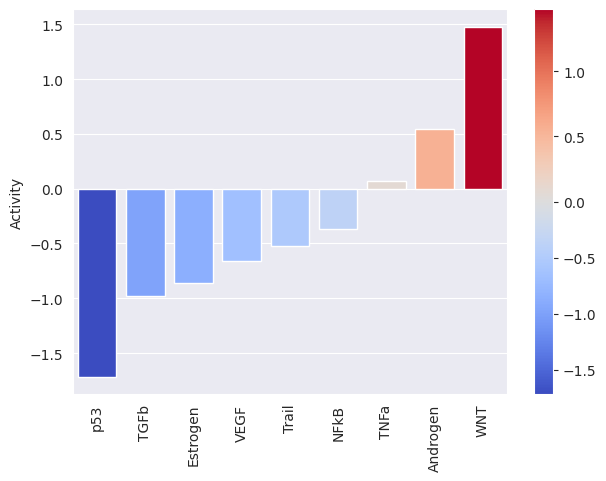

In [21]:

progeny = decoupler.get_progeny(top=300)
mat = deseq_results[["stat"]].T.rename(index={"stat": 'pydeseq_result'})

pathway_acts, pathway_pvals = decoupler.run_consensus(mat=mat, net=progeny)
decoupler.plot_barplot(pathway_acts, 'pydeseq_result', top=50, vertical=False)

print(pathway_acts)
print(pathway_pvals)